<a href="https://colab.research.google.com/github/viktorcikojevic/BEC-chemical-potential/blob/main/Wine_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:

# # URL of the white wine dataset
URI = './winequality-white.csv'

# # load the dataset from the URL
white_df = pd.read_csv(URI, sep=";")

# # fill the `is_red` column with zeros.
white_df["is_red"] = 0 

# # keep only the first of duplicate items
white_df = white_df.drop_duplicates(keep='first')


In [ ]:
# # URL of the red wine dataset
URI = './winequality-red.csv'

# # load the dataset from the URL
red_df = pd.read_csv(URI, sep=";")

# # fill the `is_red` column with ones.
red_df["is_red"] = 1 

# # keep only the first of duplicate items
red_df = red_df.drop_duplicates(keep='first')

In [ ]:
# concatenate the datesets
df = pd.concat([red_df, white_df], ignore_index=True)


In [ ]:
# shuffle the data
df = df.iloc[np.random.permutation(len(df))]

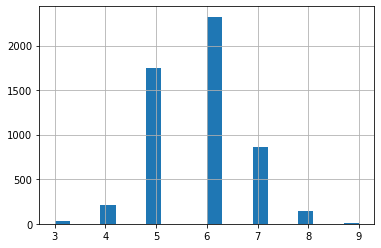

In [ ]:
df['quality'].hist(bins=20);

In [ ]:
'''
You can see from the plot above that the wine quality dataset is imbalanced.

Since there are very few observations with quality equal to 3, 4, 8 and 9, you can drop these observations from your dataset.
You can do this by removing data belonging to all classes except those > 4 and < 8.
'''

# # get data with wine quality greater than 4 and less than 8
df = df[(df['quality'] > 4) & (df['quality'] < 8 )] 

# # reset index and drop the old one
df = df.reset_index(drop=True)

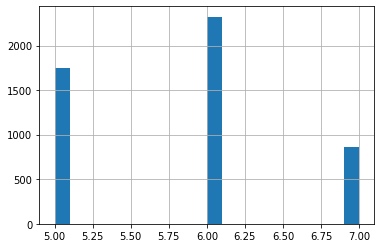

In [ ]:
df['quality'].hist(bins=20);


In [ ]:

## Please do not change the random_state parameter. This is needed for grading.

# # split df into 80:20 train and test sets
train, test = train_test_split(df, test_size=0.2, random_state=1) 
                               
# # split train into 80:20 train and val sets
train, val = train_test_split(train, test_size=0.2, random_state=1) 

In [ ]:
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()

In [ ]:
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3155.0,7.205816,1.320140,3.80000,6.4000,6.90000,7.700000,15.9000
volatile acidity,3155.0,0.338022,0.162480,0.08000,0.2300,0.29000,0.400000,1.3300
citric acid,3155.0,0.317204,0.143821,0.00000,0.2400,0.31000,0.390000,1.2300
residual sugar,3155.0,5.138193,4.460111,0.60000,1.8000,2.80000,7.700000,23.5000
chlorides,3155.0,0.055677,0.034111,0.00900,0.0380,0.04700,0.065000,0.6110
free sulfur dioxide,3155.0,30.489699,17.032927,1.00000,17.0000,29.00000,41.000000,131.0000
total sulfur dioxide,3155.0,115.761331,56.186737,6.00000,78.0000,118.00000,156.000000,313.0000
density,3155.0,0.994546,0.002885,0.98711,0.9922,0.99474,0.996745,1.0032
pH,3155.0,3.221997,0.159757,2.74000,3.1100,3.21000,3.320000,4.0100
sulphates,3155.0,0.531658,0.144198,0.22000,0.4300,0.51000,0.600000,1.9500


In [ ]:
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [ ]:
# # format the output of the train set
train_Y = format_output(train)

# # format the output of the val set
val_Y = format_output(val) 
    
# # format the output of the test set
test_Y = format_output(test) 

In [ ]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
225,5.0,0.24,0.21,2.2,0.039,31.0,100.0,0.99098,3.69,0.62,11.7
3557,7.3,0.15,0.40,2.0,0.050,24.0,92.0,0.99320,3.14,0.45,10.5
3825,7.8,0.16,0.41,1.7,0.026,29.0,140.0,0.99100,3.02,0.78,12.5
1740,7.1,0.17,0.31,1.6,0.037,15.0,103.0,0.99100,3.14,0.50,12.0
1221,5.8,0.29,0.05,0.8,0.038,11.0,30.0,0.99240,3.36,0.35,9.2


In [ ]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [ ]:
# # normalize the train set
norm_train_X = norm(train) 
    
# # normalize the val set
norm_val_X = norm(val) 
    
# # normalize the test set
norm_test_X = norm(test) 

In [ ]:
def base_model(inputs):    #     # connect a Dense layer with 128 neurons and a relu activation
    x = Dense(128, activation='relu')(inputs) # YOUR CODE HERE #     # connect another Dense layer with 128 neurons and a relu activation
    x = Dense(128, activation='relu')(x) # YOUR CODE HERE
    return x
  

In [ ]:

def final_model(inputs):
        
#     # get the base model
     x = base_model(inputs)
#     # connect the output Dense layer for regression
     wine_quality = Dense(units='1', name='wine_quality')(x)
#     # connect the output Dense layer for classification. this will use a sigmoid activation.
     wine_type = Dense(units='1', activation='sigmoid', name='wine_type')(x) 
#     # define the model using the input and output layers
     model = Model(inputs=inputs, outputs=[wine_quality, wine_type]) 

     return model

In [ ]:

inputs = tf.keras.layers.Input(shape=(11,))
rms = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model = final_model(inputs)

model.compile(optimizer=rms, 
              loss = {'wine_type' : 'binary_crossentropy', 
                       'wine_quality' : 'mse' 
                      },
               metrics = {'wine_type' : 'binary_accuracy', 
                          'wine_quality': 'RootMeanSquaredError'
                        }
              )


In [ ]:


history = model.fit( norm_train_X, train_Y,
                     epochs=180, validation_data =(norm_val_X, val_Y)   )

Epoch 1/180
99/99 [==============================] - 2s 6ms/step - loss: 25.9007 - wine_quality_loss: 25.2409 - wine_type_loss: 0.6598 - wine_quality_root_mean_squared_error: 5.0240 - wine_type_binary_accuracy: 0.6777 - val_loss: 17.9066 - val_wine_quality_loss: 17.2871 - val_wine_type_loss: 0.6195 - val_wine_quality_root_mean_squared_error: 4.1578 - val_wine_type_binary_accuracy: 0.7605
Epoch 2/180
99/99 [==============================] - 0s 3ms/step - loss: 11.7314 - wine_quality_loss: 11.1553 - wine_type_loss: 0.5761 - wine_quality_root_mean_squared_error: 3.3400 - wine_type_binary_accuracy: 0.7588 - val_loss: 6.7617 - val_wine_quality_loss: 6.2188 - val_wine_type_loss: 0.5430 - val_wine_quality_root_mean_squared_error: 2.4937 - val_wine_type_binary_accuracy: 0.7326
Epoch 3/180
99/99 [==============================] - 0s 3ms/step - loss: 4.3698 - wine_quality_loss: 3.8798 - wine_type_loss: 0.4900 - wine_quality_root_mean_squared_error: 1.9697 - wine_type_binary_accuracy: 0.7550 - va

In [ ]:
# Gather the training metrics
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')

25/25 [==============================] - 0s 2ms/step - loss: 0.3945 - wine_quality_loss: 0.3492 - wine_type_loss: 0.0453 - wine_quality_root_mean_squared_error: 0.5909 - wine_type_binary_accuracy: 0.9911

loss: 0.3945264518260956
wine_quality_loss: 0.3492109179496765
wine_type_loss: 0.04531550407409668
wine_quality_rmse: 0.5909407138824463
wine_type_accuracy: 0.9911280274391174


In [ ]:
predictions = model.predict(norm_test_X)
quality_pred = predictions[0]
type_pred = predictions[1]

In [ ]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.legend(loc="best")


In [ ]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

In [ ]:
def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

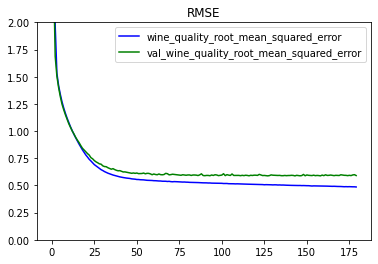

In [ ]:
plot_metrics('wine_quality_root_mean_squared_error', 'RMSE', ylim=2)

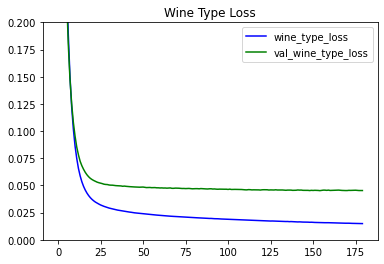

In [ ]:
plot_metrics('wine_type_loss', 'Wine Type Loss', ylim=0.2)